### Import modules

In [1]:
import rasterio
from rasterio import plot as rasterplot
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import fiona
import rasterio
import rasterio.mask
from rasterio.mask import mask
import numpy as np
import geopandas as gpd
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import mapping
import pandas as pd
import os
from xml.dom import minidom
from matplotlib import pyplot
from pyproj import CRS
from datetime import datetime
import imageio
from rasterio.transform import Affine
from rasterio.enums import ColorInterp



### Set variables

In [6]:
# Planet images (seperate folder)
fileList = glob.glob(r"K:\Projects\_Job_Requests\241381_Ballangary_Analysis\Raw\images\*.tif")

# Waterbody crest shapefile
waterbody = r"K:\Projects\_Job_Requests\241381_Ballangary_Analysis\Raw\Ballangarry_Output\Surface_Ballangary_z55.shp"
#waterbody = r"K:\Projects\_Job_Requests\241381_Ballangary_Analysis\Outputs\Ballangarry_Reservoir_z55.shp"

# Output table
#csv = r'K:\Projects\_Job_Requests\241326_Stereoscopic_accuracy\planet\waterbody_114006000244055\results\waterbody_114006000244055_crest_results.csv'
#csv = r'K:\Projects\_Job_Requests\241326_Stereoscopic_accuracy\planet\waterbody_114006000244055\results\waterbody_114006000244055_topo_results.csv'
csv = r'K:\Projects\_Job_Requests\241381_Ballangary_Analysis\Outputs\timeseries_planet_crest.csv'

# Output raster
folder = r'K:\Projects\_Job_Requests\241381_Ballangary_Analysis\Outputs\Image_clips'

# NDWI threshold value
threshold = 0.0

### Declare functions

In [7]:
def create_ndwi_4b(clip, output):

        # Load green and NIR bands - changed for 8 band
        with rasterio.open(clip) as src:
            band_grn = src.read(2)
        with rasterio.open(clip) as src:
            band_nir = src.read(4)

        # Allow division by zero
        np.seterr(divide='ignore', invalid='ignore')

        # Calculate NDWI. This is the equation at the top of this guide expressed in code
        ndwi = (band_nir.astype(float) - band_grn.astype(float)) / (band_nir + band_grn)
        
        # Set spatial characteristics of the output object to mirror the input
        kwargs = src.meta
        kwargs.update(
        dtype=rasterio.float32,
        count = 1)

        # Write band calculations to a new raster file (values over 0)
        with rasterio.open(output, 'w', **kwargs) as dst:
                dst.write_band(1, ndwi.astype(rasterio.float32))# Function to clip raster to shapefile
                
def clip_raster_to_shapefile(raster_file, shapefile, output_file):
    
    # Open shapefile using geopandas
    shp = gpd.read_file(shapefile)
    
    # Open raster file using rasterio
    with rasterio.open(raster_file) as src:
        #shp=shp.to_crs(src.crs)
        # print(Vector.crs)
        out_image, out_transform=mask(src,shp.geometry,crop=True)
        out_meta=src.meta.copy() # copy the metadata of the source DEM

    out_meta.update({
        "driver":"Gtiff",
        "height":out_image.shape[1], # height starts with shape[1]
        "width":out_image.shape[2], # width starts with shape[2]
        "transform":out_transform
    })

    with rasterio.open(output_file,'w',**out_meta) as dst:
        dst.write(out_image)    
    
# Function to classify raster into two classes based on a threshold
def classify_raster(raster_file, threshold, output_file):
    with rasterio.open(raster_file) as src:
        # Read raster band 1
        band1 = src.read(1)

        # Apply classification based on threshold
        classified = np.where(band1 <= threshold, 0, 1)

        # Update metadata
        out_meta = src.meta.copy()

    # Write the classified raster to a new file
    with rasterio.open(output_file, "w", **out_meta) as dest:
        dest.write(classified, 1)

# Function to measure the area of the raster above the threshold
def measure_area_above_threshold(raster_file, threshold):
    with rasterio.open(raster_file) as src:
        # Read raster band 1
        band1 = src.read(1)

        # Apply classification based on threshold
        classified = np.where(band1 < threshold, 1, 0)

        # Identify NoData values
        nodata = src.nodata

        # Exclude NoData values from calculation
        valid_values = np.logical_not(np.isnan(band1)) & np.logical_not(np.isclose(band1, nodata))

        # Calculate the area of cells above the threshold
        # Get the affine transformation
        transform = src.transform

        # Get the cell size in square meters
        x_res = transform[0]
        y_res = transform[4]
        cell_area_m2 = abs(x_res * y_res)

        # Calculate total area
        total_area = np.sum(valid_values) * cell_area_m2

        # Calculate area above threshold
        area_below_threshold = np.sum(classified) * cell_area_m2

        # Calculate percentage below threshold
        percentage_below_threshold = (area_below_threshold / total_area) * 100

    return total_area, area_below_threshold, percentage_below_threshold

### Check projection and overlap

shapefile CRS:  epsg:32755
image CRS:  EPSG:32755
Projections match


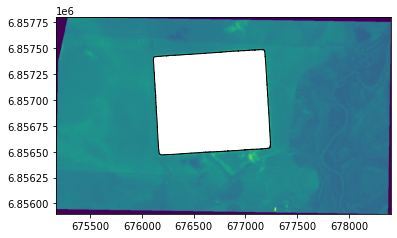

In [8]:
# Open shapefile using geopandas
shp = gpd.read_file(waterbody)

## reading the first tiff file:    
raster_image = rasterio.open(fileList[1])
tiff_band_1 = raster_image.read(1)

print('shapefile CRS: ', shp.crs)
print('image CRS: ', raster_image.crs)

if shp.crs != raster_image.crs:
    print('projections do not match')
    shp = shp.to_crs({'init': 'EPSG:32756'})    
    print('shapefile CRS: ', shp.crs)
    print('image CRS: ', raster_image.crs)
else:
    print('Projections match')
    
# Get raster extent
raster_extent = [raster_image.bounds[0], raster_image.bounds[2], raster_image.bounds[1], raster_image.bounds[3]]

# Create a new plot
f, ax = plt.subplots()

# plot DEM
rasterplot.show(
    tiff_band_1,  # use tiff.read(1) with your data
    extent=raster_extent,
    ax=ax,
)

# plot shapefiles
shp.plot(ax=ax, facecolor='w', edgecolor='k')
plt.savefig('test.jpg')
plt.show()

with rasterio.open(fileList[1]) as src:
    #shp=shp.to_crs(src.crs)
    # print(Vector.crs)
    out_image, out_transform=mask(src,shp.geometry,crop=True)
    out_meta=src.meta.copy() # copy the metadata of the source DEM
    
out_meta.update({
    "driver":"Gtiff",
    "height":out_image.shape[1], # height starts with shape[1]
    "width":out_image.shape[2], # width starts with shape[2]
    "transform":out_transform
})

### Loop through images

In [9]:
# Initialize empty DataFrame
df = pd.DataFrame(columns=["Image Name", "Image Date", "Total Area", "NDWI Area", "NDWI Percentage"])

# Loop through image folder
for image in fileList:
    
    # Get the image name and date
    image_name = os.path.basename(image)
    image_date = image_name[:8]
    image_date = datetime.strptime(image_date, '%Y%m%d').strftime('%d/%m/%Y')
    print("\nProcessing date: " + image_date)
    
    # create output file name
    clip = folder + "\\RGB_" + image_name[:8] + ".png"  
    output = folder + "\\NDWI_" + image_name[:8] + ".png"
    
    # Clip image
    try:
        print("Clipping image")
        clip_raster_to_shapefile(image, waterbody, clip)     
    except:      
        print("Clipping failed")
    
    # Create NDWI
    #try:   
    print("Creating NDWI")

    # Load green and NIR bands - changed for 4 band
    with rasterio.open(clip) as src:
        band_grn = src.read(2)
    with rasterio.open(clip) as src:
        band_nir = src.read(4)

    # Allow division by zero
    np.seterr(divide='ignore', invalid='ignore')

    # Calculate NDWI. This is the equation at the top of this guide expressed in code
    ndwi = (band_nir.astype(float) - band_grn.astype(float)) / (band_nir + band_grn)

    # Set spatial characteristics of the output object to mirror the input
    kwargs = src.meta
    kwargs.update(
    dtype=rasterio.float32,
    count = 1)

    # Define color map
    blue_color_map = {
        'blue': [(0, 1, 1), (1, 0, 0)]  # Blue color ramp from white to blue
    }

    # Define color interpretation
    color_interp = [ColorInterp.blue]

    # Create transformation matrix
    transform = Affine(30.0, 0.0, 0.0, 0.0, -30.0, 0.0)        

    # Write band calculations to a new raster file (values over 0)
    with rasterio.open(output, 'w', **kwargs) as dst:
            dst.write_colormap(1, blue_color_map)
            dst.write_band(1, ndwi.astype(rasterio.float32))
                
    #except:
    #    print("NDWI failed")
    
    # Measure surface area
    try:
        print("Measuring surface area")
        
        # Measure areas    
        total_area, area_above_threshold, percentage_above_threshold = measure_area_above_threshold(output, threshold)
        print("Total Area:", total_area, "square meters")
        print("NDWI Area:", area_above_threshold, "square meters")
        print("NDWI Percentage:", percentage_above_threshold, "%")

        # Append results to DataFrame
        df = df.append({
            "Image Name": image_name,
            "Image Date": image_date,
            "Total Area": total_area,
            "NDWI Area": area_above_threshold,
            "NDWI Percentage": percentage_above_threshold
        }, ignore_index=True)
            
    except:
        print("Area measurement failed")     
        
# Print DataFrame
print(df)

# Save DataFrame to CSV
df.to_csv(csv, index=False)

# Completion message
print("Completed")


Processing date: 04/12/2023
Clipping image
Creating NDWI
Measuring surface area
Total Area: 1033452.0 square meters
NDWI Area: 887868.0 square meters
NDWI Percentage: 85.91284355732051 %

Processing date: 05/12/2023
Clipping image
Creating NDWI
Measuring surface area
Total Area: 1033848.0 square meters
NDWI Area: 1031436.0 square meters
NDWI Percentage: 99.7666968451842 %

Processing date: 05/12/2023
Clipping image
Creating NDWI
Measuring surface area
Area measurement failed

Processing date: 07/12/2023
Clipping image
Creating NDWI
Measuring surface area
Total Area: 1033344.0 square meters
NDWI Area: 876294.0 square meters
NDWI Percentage: 84.80176978818284 %

Processing date: 08/12/2023
Clipping image
Creating NDWI
Measuring surface area
Total Area: 1033839.0 square meters
NDWI Area: 1030815.0 square meters
NDWI Percentage: 99.70749797599045 %

Processing date: 08/12/2023
Clipping image
Creating NDWI
Measuring surface area
Area measurement failed

Processing date: 10/12/2023
Clipping

Creating NDWI
Measuring surface area
Area measurement failed

Processing date: 21/02/2024
Clipping image
Creating NDWI
Measuring surface area
Total Area: 1033821.0 square meters
NDWI Area: 1028430.0 square meters
NDWI Percentage: 99.47853641974771 %

Processing date: 21/02/2024
Clipping image
Creating NDWI
Measuring surface area
Area measurement failed

Processing date: 22/02/2024
Clipping image
Creating NDWI
Measuring surface area
Total Area: 1033848.0 square meters
NDWI Area: 1029501.0 square meters
NDWI Percentage: 99.57953200083571 %

Processing date: 22/02/2024
Clipping image
Creating NDWI
Measuring surface area
Area measurement failed

Processing date: 23/02/2024
Clipping image
Creating NDWI
Measuring surface area
Total Area: 1033857.0 square meters
NDWI Area: 1030068.0 square meters
NDWI Percentage: 99.63350830917622 %

Processing date: 23/02/2024
Clipping image
Creating NDWI
Measuring surface area
Area measurement failed

Processing date: 01/03/2024
Clipping image
Creating NDWI

Measuring surface area
Area measurement failed

Processing date: 17/04/2024
Clipping image
Creating NDWI
Measuring surface area
Total Area: 1028376.0 square meters
NDWI Area: 687402.0 square meters
NDWI Percentage: 66.84345025554855 %

Processing date: 19/04/2024
Clipping image
Creating NDWI
Measuring surface area
Total Area: 1029600.0 square meters
NDWI Area: 736191.0 square meters
NDWI Percentage: 71.50262237762239 %

Processing date: 19/04/2024
Clipping image
Creating NDWI
Measuring surface area
Total Area: 1029330.0 square meters
NDWI Area: 733968.0 square meters
NDWI Percentage: 71.30541225845938 %

Processing date: 22/04/2024
Clipping image
Creating NDWI
Measuring surface area
Total Area: 1033866.0 square meters
NDWI Area: 1033803.0 square meters
NDWI Percentage: 99.99390636697599 %

Processing date: 22/04/2024
Clipping image
Creating NDWI
Measuring surface area
Area measurement failed

Processing date: 25/04/2024
Clipping image
Creating NDWI
Measuring surface area
Total Area: 10